In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(0), float(1), int(50))
one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
train_y = torch.stack([one, two], int(-1))


In [3]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )

        kernel0 = Diff_SE_kernel()
        kernel1 = Diff_SE_kernel()
        kernel2 = Diff_SE_kernel()
        self.covar_module = MatrixKernel([[kernel0, None], [None, kernel2]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(20)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[1.0001, 0.9998, 0.9992,  ..., 0.0000, 0.0000, 0.0000],
        [0.9998, 1.0001, 0.9998,  ..., 0.0000, 0.0000, 0.0000],
        [0.9992, 0.9998, 1.0001,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0001, 0.9998, 0.9992],
        [0.0000, 0.0000, 0.0000,  ..., 0.9998, 1.0001, 0.9998],
        [0.0000, 0.0000, 0.0000,  ..., 0.9992, 0.9998, 1.0001]],
       grad_fn=<CatBackward>)
tensor([[1.1001, 1.0997, 1.0989,  ..., 0.0000, 0.0000, 0.0000],
        [1.0997, 1.1001, 1.0997,  ..., 0.0000, 0.0000, 0.0000],
        [1.0989, 1.0997, 1.1001,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.9001, 0.8998, 0.8991],
        [0.0000, 0.0000, 0.0000,  ..., 0.8998, 0.9001, 0.8998],
        [0.0000, 0.0000, 0.0000,  ..., 0.8991, 0.8998, 0.9001]],
       grad_fn=<CatBackward>)
tensor([[1.1528, 1.1523, 1.1512,  ..., 0.0000, 0.0000, 0.0000],
        [1.1523, 1.1528, 1.1523,  ..., 0.0000, 0.0000, 0.0000],
        [1.1512,

In [5]:
for p in model.named_parameters():
    print(p)

('likelihood.raw_task_noises', Parameter containing:
tensor([-2.0356, -2.0631], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-2.0513], requires_grad=True))
('covar_module.kernel_00.var', Parameter containing:
tensor(0.4487, requires_grad=True))
('covar_module.kernel_00.length', Parameter containing:
tensor(0.2011, requires_grad=True))
('covar_module.kernel_11.var', Parameter containing:
tensor(1.3729, requires_grad=True))
('covar_module.kernel_11.length', Parameter containing:
tensor(0.3551, requires_grad=True))


In [6]:
tuple([1,2])

(1, 2)

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(50)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(0), float(2), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


tensor([[0.4488, 0.4464, 0.4396,  ..., 0.0000, 0.0000, 0.0000],
        [0.4464, 0.4488, 0.4464,  ..., 0.0000, 0.0000, 0.0000],
        [0.4396, 0.4464, 0.4488,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.3730, 1.3706, 1.3639],
        [0.0000, 0.0000, 0.0000,  ..., 1.3706, 1.3730, 1.3706],
        [0.0000, 0.0000, 0.0000,  ..., 1.3639, 1.3706, 1.3730]])
tensor([[0.4488, 0.4464, 0.4396,  ..., 0.0000, 0.0000, 0.0000],
        [0.4464, 0.4488, 0.4464,  ..., 0.0000, 0.0000, 0.0000],
        [0.4396, 0.4464, 0.4488,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.3730, 1.3639, 1.3371],
        [0.0000, 0.0000, 0.0000,  ..., 1.3639, 1.3730, 1.3639],
        [0.0000, 0.0000, 0.0000,  ..., 1.3371, 1.3639, 1.3730]])


Text(0.5, 1.0, 'Observed Values (Likelihood)')

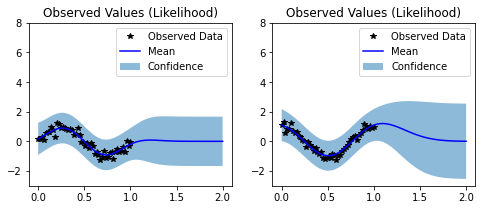

In [8]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(3)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 8])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 8])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


# Test Diffable SE Kernel

In [9]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [10]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = SE.diff(x2).diff(x1)(int(v1), int(v2), lengthscale, variance)
cov_matr

[[1, 0, -3*e^(-2)], [0, 1, 0], [-3*e^(-2), 0, 1]]

In [11]:
SE.operands()

[sigma^2, e^(-1/2*(x1 - x2)^2/l^2)]

In [12]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate()

tensor([[ 1.0000,  0.0000, -0.4060],
        [ 0.0000,  1.0000,  0.0000],
        [-0.4060,  0.0000,  1.0000]], grad_fn=<MulBackward0>)

In [13]:
def calc_cell_diff(L, M, R, row, col):
    len_M = M.number_of_arguments()
    temp = None
    for j in range(int(sqrt(len_M))):
        if temp == None:
            import itertools
            #M_tr = list(map(list, itertools.zip_longest(*M, fillvalue=None)))
            #[M_tr[j].diff(left_poly=L[row][k], right_poly=R.transpose()[col][j]) for k in range(L.number_of_arguments())]
            temp = L[row]*M.transpose()[j]*R.transpose()[col][j]
        else:
            temp += L[row]*M.transpose()[j]*R.transpose()[col][j]
    return temp

In [30]:
dimension = 2
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 1
col = 0
print((L*M*R)[row][col])

calc_cell_diff(L, M, R, row, col)

[l_11 l_12]
[l_21 l_22]
[m_11 m_12]
[m_21 m_22]
[r_11 r_12]
[r_21 r_22]
(l_21*m_11 + l_22*m_21)*r_11 + (l_21*m_12 + l_22*m_22)*r_21


(l_21*m_11 + l_22*m_21)*r_11 + (l_21*m_12 + l_22*m_22)*r_21

In [31]:
from itertools import product
for p in product(L.rows(),R.columns()):
    print(p)

((l_11, l_12), (r_11, r_21))
((l_11, l_12), (r_12, r_22))
((l_21, l_22), (r_11, r_21))
((l_21, l_22), (r_12, r_22))


In [16]:
MSE(x1, x2, sigma, l) = matrix(2,2, (sigma^2*exp(-(x1-x2)^2/(2*l^2)), 0, 0, sigma^2*exp(-(x1-x2)^2/(2*l^2))))
dx1 = matrix(2,2,(dx1, 0, 0, dx1))
MSE

(x1, x2, sigma, l) |--> [sigma^2*e^(-1/2*(x1 - x2)^2/l^2)                                0]
[                               0 sigma^2*e^(-1/2*(x1 - x2)^2/l^2)]

In [33]:
kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])

In [37]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [40]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

tensor([[ 1.0000,  0.0000, -0.4060,  1.0000,  0.0000, -0.4060],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.4060,  0.0000,  1.0000, -0.4060,  0.0000,  1.0000],
        [ 1.0000,  0.0000, -0.4060,  1.0000,  0.0000, -0.4060],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.4060,  0.0000,  1.0000, -0.4060,  0.0000,  1.0000]],
       grad_fn=<CatBackward>)


tensor([[ 1.0000,  1.0000,  0.0000,  0.0000, -0.4060, -0.4060],
        [ 1.0000,  1.0000,  0.0000,  0.0000, -0.4060, -0.4060],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.4060, -0.4060,  0.0000,  0.0000,  1.0000,  1.0000],
        [-0.4060, -0.4060,  0.0000,  0.0000,  1.0000,  1.0000]],
       grad_fn=<CatBackward>)